<div style="width: 100%; margin-left: auto; margin-right: auto;">
    <h2 style="text-align: center; margin-top: 1%; font-size:32px;">Avaliação de Desempenho - Atividade 4</h2>
</div>

**Aluno:** Igor Carvalho da Silva  
**Email:** igor.carvalho@icomp.ufam.edu.br  
**Matrícula:** 21951288  

---

## Introdução
As filas têm uma frequente incidência no cotidiano, seja de uma forma mais perceptível como na compra de ingressos para um show ou cinema, em uma sala de espera de um consultório, ou ainda, de uma forma menos perceptível como no gerenciamento de documentos a serem impressos ou no buffer para gravação de dados em mídia. As filas são fenômenos naturais em um mundo compartilhado, além de ser uma das estruturas de dados mais utilizada na área de Computação.

Nesta atividade simulamos a dinâmica de uma fila M/M/1 a fim de estimar o tempo médio $\bar{X}(n)$ de espera de um cliente na fila. Para isso, foi realizada uma Simulação de Horizonte Infinito, onde o fim da simulação ocorre quando uma determinada condição acontece, neste experimento foi usado o Tamanho Relativo que leva em consideração o tamanho relativo do intervalo de confiança em relação ao valor sendo estimado.

Devido a inicialização arbitrária dos parâmetros de configuração do modelo de simulação é introduzido um viés nos estimadores que pode ser reduzido se eliminarmos as observações coletadas no estado transiente. Dessa forma, aplicou-se a heurística MSER-5Y para encontrar o fim do transiente, preservando o máximo da sequência original.

Porém surge um outro viés, as observações restantes, denominadas de estado estacionário, possuem forte correlação entre si o que introduz viés na estimativa final da média , nossa métrica de interesse. Com isso, neste experimento é proposto usar o método Batch Means para diminuir a correlação das observações. O experimento foi dividido em três partes, a primeira aplicando o método Batch Means sem overlapping, a segunda aplicando o método Overlapping Batch Means e por fim na terceira parte aplicando o método Overlapping Batch Means com graus de superposições.


## Experimento
### Dependências
Para reproduzir o experimento é necessário ter o `pip` instalado ou já possuir as bibliotecas instaladas.

In [ ]:
!pip3 install numpy
!pip3 install tqdm
!pip3 install scipy
!pip3 install statistics
!pip3 install matplotlib

### Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from statistics import pstdev
from scipy.stats import t
from math import sqrt, ceil
from tqdm import tqdm

### Funções

In [2]:
def generate_exponential_VA(beta):
    return -beta * np.log(1-random.random())

def waiting_times_generator(N, lambda_, mu, debug=False):
    arrival_time = 0
    exit_time = 0
    waiting_times = []
    if debug:
        print(f'Simulação para {N} clientes')

    for _ in tqdm(range(N), disable=not debug):
        arrival_time += generate_exponential_VA(1/lambda_)
        service_time = generate_exponential_VA(1/mu)

        if arrival_time >= exit_time:
            waiting_times.append(0)
            exit_time = arrival_time + service_time
        else:
            waiting_times.append(exit_time - arrival_time)
            exit_time += service_time

    return waiting_times

def metrics(observations, N, blocks_num=0, debug=False):
    if debug:
        print('Gerando métricas ... ', end='')
    mean = np.mean(observations)
    standard_deviation = pstdev(observations)
    
    if blocks_num != 0:
        t_ = t.ppf(0.95, 1.5*(N-1))
        h = (t_ * standard_deviation) / sqrt(blocks_num)
    else:
        t_ = t.ppf(0.95, N-1)
        h = (t_ * standard_deviation) / sqrt(N)
        
    if debug:
        print('done!')
    
    return (mean, h)

def mser5(k,d,z):
    z_mean = round(sum(z[d:k])/(k-d),5)
    variance = sum([(zj-z_mean)**2 for zj in z[d:k]])/(k-d)
    std_deviation = sqrt(variance)
    
    return std_deviation/sqrt(k-d)

def mser_validation(results, progress):
    mser_left = results[:-progress]
    mser_right = results[-progress:]
    
    mser_left.sort()
    if(mser_left[0][0] == mser_left[1][0]):
        return (False, -1)
    
    mser_right.sort()
    if(mser_right[0][0] < mser_left[0][0]):
        return (False, -1)
    
    return (True, mser_left[0][1])
    
def mser5y(observations, progress=0.0):
    results = []
    k = len(observations)//5
    z_series = [np.mean(observations[i:i+5]) for i in range(0, len(observations), 5)]
    
    right_blocks = ceil(k*progress)
    for d in range(k//2 + right_blocks):
        results.append((mser5(k,d,z_series),d))
    
    is_valid, trunc_point = mser_validation(results, right_blocks)
    
    if is_valid:
        return trunc_point*5
    else:
        return -1
        
def plot_graph(results, expected_results):
    fig, ax = plt.subplots()

    avgs, error_margin = zip(*results)
    colors = ['red', 'blue', 'green', 'brown']
    x = [1,2,3,4]

    for pos, y, err, color, expected in zip(x, avgs, error_margin, colors, expected_means): 
        ax.errorbar(pos, y, yerr=err, fmt='o', c=color, mec='black', ms=7, ecolor='black', capsize=5)
        ax.axhline(y=expected, c=color, linestyle='--', label=f'Média esperada C-{pos}')

    plt.xticks([1,2,3,4], ['C-1','C-2','C-3','C-4'])
    plt.margins(0.2)
    plt.ylabel('Tempo médio de espera', fontsize=14)
    plt.xlabel('Cenários', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
def batch_means(observations, b, m, overlap=0):
    block_means = []
    
    if overlap == 0:
        overlap = m
    
    for i in range(b):
        i = i*overlap
        block = observations[i:i+m]
        block_means.append(sum(block)/m)
    
    return block_means

def von_neuman_test(block_means, critical_value=1.29):
    b = len(block_means)
    r = [0]*b
    for i, mean in enumerate(block_means):
        for next_ in block_means:
            if next_ <= mean:
                r[i] += 1

    r_mean = sum(r)/b
    rnv = sum([(r[i]-r[i+1])**2 for i in range(b-1)])/sum([(ri - r_mean)**2 for ri in r])
    
    return rnv < critical_value

### Constantes

In [3]:
#(lambda, mu)
scenarios = [
    (1, 7, 10),
    (2, 8, 10),
    (3, 9, 10),
    (4, 9.5, 10)
]
expected_means = [lambda_/mu*((1/mu)/(1-lambda_/mu)) for _, lambda_, mu in scenarios]

### Parte 1

Executar uma simulação de horizonte infinito para estimar o tempo médio de espera em uma fila M/M/1.

Eliminar o transiente usando a heurística MSER -5Y.

Usar o método Batch Means para estimar o tempo médio de espera na fila e o respectivo intervalo de confiança de 95%.

A regra de parada é a precisão relativa de 5%.

Cenário I: λ = 7 clientes por segundo; μ =10 clientes por segundo.

Cenário II: λ = 8 clientes por segundo; μ =10 clientes por segundo.

Cenário III: λ = 9 clientes por segundo; μ =10 clientes por segundo.

Cenário IV: λ = 9,5 clientes por segundo; μ =10 clientes por segundo.

Plotar um gráfico comparativo dos quatro cenários.

Plotar uma linha horizontal para o valor teórico esperado em cada cenário.

In [4]:
results = []
for i, lambda_, mu in scenarios:
    print(f'Cenário {i}')
    b = 20
    m = 100
    waiting_times = []

    print('Iniciando fase transiente')
    while True:
        waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
        trunc_point = mser5y(waiting_times, progress=0.01)

        if trunc_point != -1:
            waiting_times = waiting_times[trunc_point:]
            break;
        m += 100
        
    if len(waiting_times) < b*m:
        waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
                
    print('Iniciando fase correlação')
    block_means = batch_means(waiting_times, b, m)
    while not von_neuman_test(block_means):
        m += 100
        waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
        block_means = batch_means(waiting_times, b, m)
    
    print('Iniciando fase de estimação')
    while True:              
        mean, h = metrics(block_means, b*m)
        relative_size = h/mean
    
        if relative_size <= 0.05:
            break;
        
        m += 100
        waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
        block_means = batch_means(waiting_times, b, m)
    results.append((mean, h))
    print('-'*10)

Cenário 1
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 2
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 3
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 4
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------


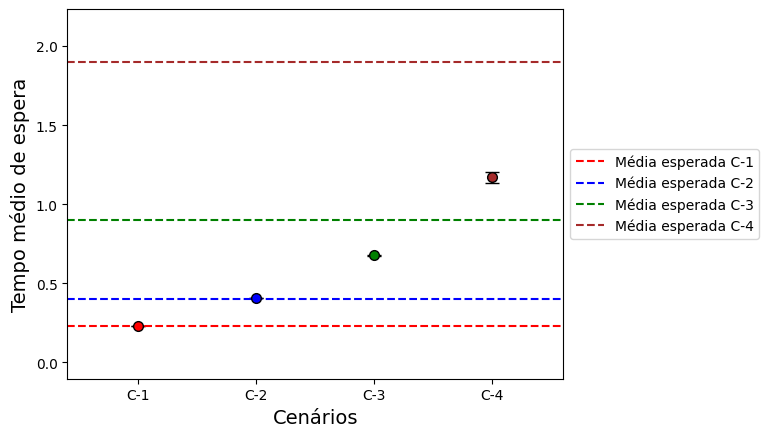

In [5]:
plot_graph(results, expected_means)

### Parte 2

Executar uma simulação de horizonte infinito para estimar o tempo médio de espera em uma fila M/M/1.

Eliminar o transiente usando a heurística MSER -5Y.

Usar o método Overpapping Batch Means para estimar o tempo médio de espera na fila e o respectivo intervalo de confiança de 95%.

A regra de parada é a precisão relativa de 5%.

Cenário I: λ = 7 clientes por segundo; μ =10 clientes por segundo.

Cenário II: λ = 8 clientes por segundo; μ =10 clientes por segundo.

Cenário III: λ = 9 clientes por segundo; μ =10 clientes por segundo.

Cenário IV: λ = 9,5 clientes por segundo; μ =10 clientes por segundo.

Plotar um gráfico comparativo dos quatro cenários.

Plotar uma linha horizontal para o valor teórico esperado em cada cenário.

In [6]:
results = []
blocks_num = lambda m, n: n - m + 1
for i, lambda_, mu in scenarios:
    b = 20
    m = 100
    print(f'Cenário {i}')
    waiting_times = []

    print('Iniciando fase transiente')
    while True:
        waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
        trunc_point = mser5y(waiting_times, progress=0.01)

        if trunc_point != -1:
            waiting_times = waiting_times[trunc_point:]
            break;
        m += 100
        b = blocks_num(m, len(waiting_times))
        
    if len(waiting_times) < b*m:
        waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
                
    print('Iniciando fase correlação')
    block_means = batch_means(waiting_times, b, m, overlap=1)
    while not von_neuman_test(block_means):
        m += 100
        b = blocks_num(m, len(waiting_times))
        waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
        blocks_means = batch_means(waiting_times, b, m, overlap=1)
    
    print('Iniciando fase de estimação')
    while True:              
        mean, h = metrics(block_means, b*m, b)
        relative_size = h/mean
    
        if relative_size <= 0.05:
            break;
        
        m += 100
        b = blocks_num(m, len(waiting_times)) 
        waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
        block_means = batch_means(waiting_times, b, m, overlap=1)
    results.append((mean, h))
    print('-'*10)

Cenário 1
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 2
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 3
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 4
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------


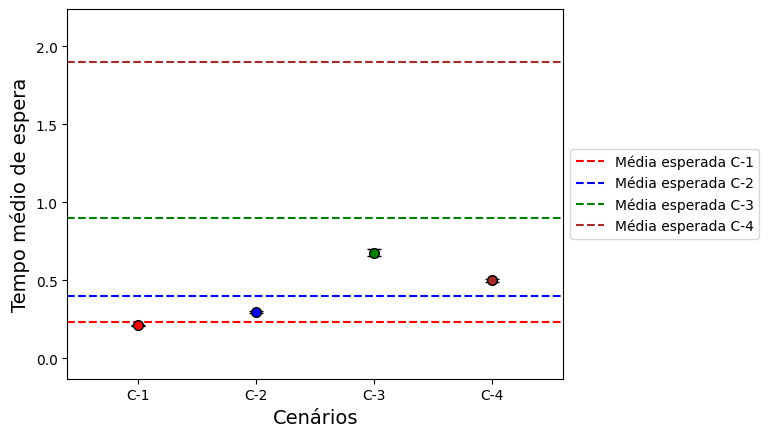

In [7]:
plot_graph(results, expected_means)

### Parte 3

Executar uma simulação de horizonte infinito para estimar o tempo médio de espera em uma fila M/M/1.

Eliminar o transiente usando a heurística MSER -5Y.

Usar o método Overpapping Batch Means para estimar o tempo médio de espera na fila e o respectivo intervalo de confiança de 95%.

A regra de parada é a precisão relativa de 5%.

Cenário I: λ = 7 clientes por segundo; μ =10 clientes por segundo.

Cenário II: λ = 8 clientes por segundo; μ =10 clientes por segundo.

Cenário III: λ = 9 clientes por segundo; μ =10 clientes por segundo.

Cenário IV: λ = 9,5 clientes por segundo; μ =10 clientes por segundo.

Plotar um gráfico comparativo dos quatro cenários.

Plotar uma linha horizontal para o valor teórico esperado em cada cenário.

Repetir para diferentes graus de superposição (overlap): 10%, 25% e 50%.

In [11]:
results_of_results = []
overlaps_degree = [10, 25, 50]
for over_degree in overlaps_degree:
    results = []
    blocks_num = lambda m, n: n - m + 1
    for i, lambda_, mu in scenarios:
        b = 20
        m = 100
        print(f'Cenário {i} - Degree {over_degree}%')
        waiting_times = []

        print('Iniciando fase transiente')
        while True:
            waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
            trunc_point = mser5y(waiting_times, progress=0.01)

            if trunc_point != -1:
                waiting_times = waiting_times[trunc_point:]
                break;
            m += 100
            b = blocks_num(m, len(waiting_times))

        if len(waiting_times) < b*m:
            waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)

        print('Iniciando fase correlação')
        block_means = batch_means(waiting_times, b, m, overlap=over_degree*m//100)
        while not von_neuman_test(block_means):
            m += 100
            b = blocks_num(m, len(waiting_times))
            waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
            blocks_means = batch_means(waiting_times, b, m, overlap=over_degree*m//100)

        print('Iniciando fase de estimação')
        while True:              
            mean, h = metrics(block_means, b*m, b)
            relative_size = h/mean

            if relative_size <= 0.05:
                break;

            m += 100
            b = blocks_num(m, len(waiting_times)) 
            waiting_times += waiting_times_generator(b*m - len(waiting_times), lambda_, mu)
            block_means = batch_means(waiting_times, b, m, overlap=over_degree*m//100)
        results.append((mean, h))
        print('-'*10)
    results_of_results.append(results)

Cenário 1 - Degree 10%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 2 - Degree 10%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 3 - Degree 10%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 4 - Degree 10%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 1 - Degree 25%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 2 - Degree 25%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 3 - Degree 25%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 4 - Degree 25%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fase de estimação
----------
Cenário 1 - Degree 50%
Iniciando fase transiente
Iniciando fase correlação
Iniciando fas

OVERLAP 10%


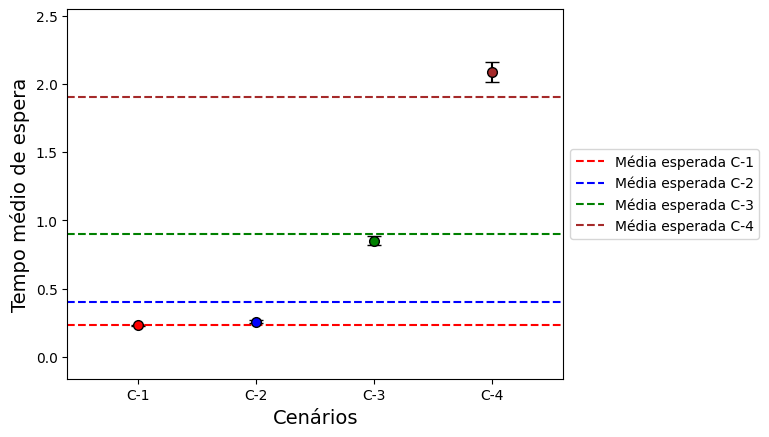

OVERLAP 25%


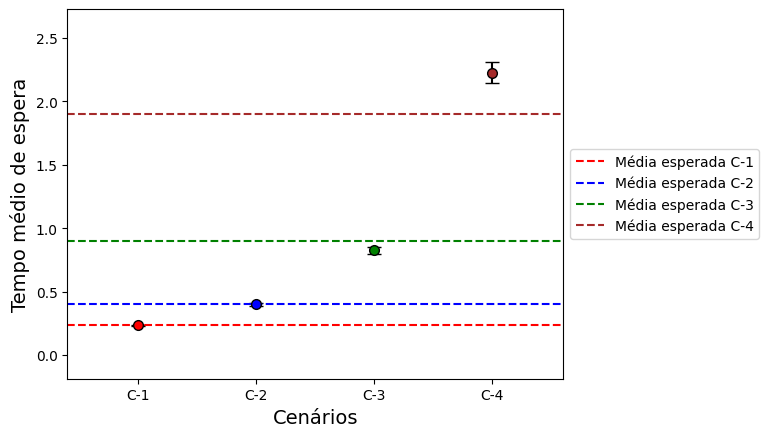

OVERLAP 50%


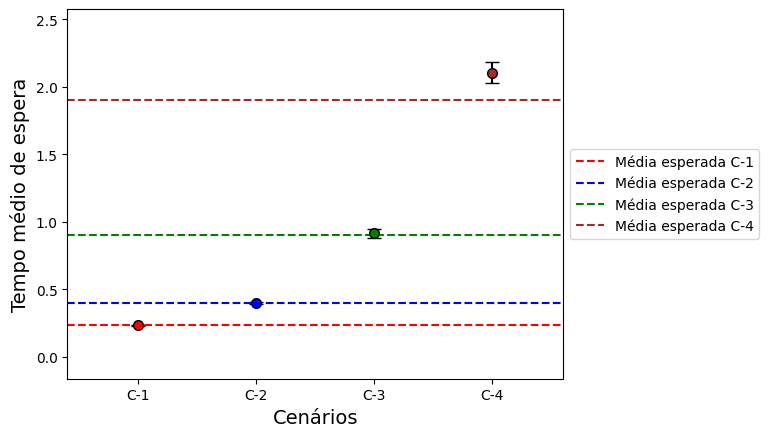

In [12]:
for overlap, results in zip(overlaps_degree,results_of_results):
    print(f'OVERLAP {overlap}%')
    plot_graph(results, expected_means)

## Conclusão
Analisando os gráficos presentes em cada parte do experimento, podemos observar que mesmo diminuindo a correlação das observações conforme o crescimento da taxa de chegada dos clientes e o valor constante no tempo de serviço, os valores observados ficaram cada vez mais distantes da média esperada.

Se compararmos o método Batch Means com e sem overlapping observamos que para o método com overlapping usado na Parte 2, os resultados foram pouco satisfatórios quando comparados ao método sem overlapping mostrando na Parte 1 do experimento. Porém, na Parte 3 observamos que usando graus de superposição os resultados tendem a se aproximar da média esperada, destacando o método Overlapping Batch Means com grau de superposição de 25% que obteve resultados satisfatórios para os quatros cenários obtendo as médias observadas muito próximas da média esperada.